In [1]:
import pandas as pd
from sklearn.cluster import KMeans
import numpy as np
from collections import defaultdict
from matplotlib import pyplot as plt
import pickle
import seaborn as sns
sns.set()
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from itertools import combinations

# Extracting chunks from csvs

In [2]:
data_13_14 = pd.read_csv("./Parking_Violations_Issued_-_Fiscal_Year_2014__August_2013___June_2014_.csv",
                        chunksize=20)
# data_15 = pd.read_csv("./Parking_Violations_Issued_-_Fiscal_Year_2015.csv",
#                       chunksize=20)
# data_16 = pd.read_csv("./Parking_Violations_Issued_-_Fiscal_Year_2016.csv",
#                      chunksize=20)
# data_17 = pd.read_csv("./Parking_Violations_Issued_-_Fiscal_Year_2017.csv",
#                     chunksize=20)

In [3]:
data = {'13_14':data_13_14,
        '15':data_15,
        '16':data_16,
        '17':data_17}
chunks = {}
for year,csv in data.items():
    for chunk in csv:
        chunks[year] = chunk
        break
print(chunks)

{'13_14':     Summons Number Plate ID Registration State Plate Type  Issue Date  \
0       1283294138  GBB9093                 NY        PAS  08/04/2013   
1       1283294151  62416MB                 NY        COM  08/04/2013   
2       1283294163  78755JZ                 NY        COM  08/05/2013   
3       1283294175  63009MA                 NY        COM  08/05/2013   
4       1283294187  91648MC                 NY        COM  08/08/2013   
5       1283294217   T60DAR                 NJ        PAS  08/11/2013   
6       1283294229  GCR2838                 NY        PAS  08/11/2013   
7       1283983620   XZ764G                 NJ        PAS  08/07/2013   
8       1283983631  GBH9379                 NY        PAS  08/07/2013   
9       1283983667   MCL78B                 NJ        PAS  07/18/2013   
10      1283983679   M367CN                 NY        PAS  07/18/2013   
11      1283983734  GAR6813                 NY        PAS  07/18/2013   
12      1283983771  GEN8674              

# Checking whether cols in all csvs are the same

In [10]:
col_list = defaultdict(list)

for year,chunk in chunks.items():
    for col in chunk:
        col_list[year].append(col)

In [13]:
all(set(col_list['13_14'])==set(year_list) for year,year_list in col_list.items() if year != '13_14')
    

False

### NOTE : all cols are the same except for year 2017

In [19]:
col_list['13_14'] == col_list['15'] == col_list['16'] 

True

In [20]:
col_list['13_14'] == col_list['17']

False

In [23]:
for col in col_list['13_14']:
    if col not in col_list['17']:
        print(col)

Latitude
Longitude
Community Board
Community Council 
Census Tract
BIN
BBL
NTA


## cols absent in 2017 .csv are not very important

### cols considered for K-means clustering
 - Vehicle Expiration Date: Number
 - Violation Precinct: Number
 - Issuer Precinct: Number
 - Date First Observed: Number
 - Vehicle Year: Number

These cols contain dates where the date will be converted to the day of the year which will vary from 1 to 365 (or 366 in case of leap year)

# 2013-14 data

### Checking Violation Precinct Data

In [10]:
set(chunks['13_14']['Violation Precinct'])

{13, 33, 71, 76, 78, 79, 81, 88}

In [11]:
set(chunks['15']['Violation Precinct'])

{5, 7, 9, 14, 19, 25, 28, 48, 67, 72, 78, 79, 102, 103, 109, 110, 113}

In [12]:
set(chunks['16']['Violation Precinct'])

{0, 74, 79, 88, 94}

In [12]:
set(chunks['17']['Violation Precinct'])

{0, 13, 14, 17, 18, 44, 71, 73, 106, 120}

### Checking Issuer Precinct Data

In [11]:
set(chunks['13_14']['Issuer Precinct'])

{0, 13, 33, 730, 976}

In [14]:
for year in chunks.keys():
    print("set(chunks[%s]['Issuer Precinct'])" % year,set(chunks[year]['Issuer Precinct']))

set(chunks[13_14]['Issuer Precinct']) {0, 33, 13, 976, 730}
set(chunks[15]['Issuer Precinct']) {67, 5, 102, 7, 72, 103, 9, 109, 78, 79, 110, 113, 14, 19, 48, 25, 28}
set(chunks[16]['Issuer Precinct']) {0, 301}
set(chunks[17]['Issuer Precinct']) {0, 71, 73, 106, 44, 13, 14, 17, 18, 120}


In [22]:
reqd_cols = ['Vehicle Expiration Date',
             'Violation Precinct',
             'Issuer Precinct',
             'Date First Observed',
             'Vehicle Year']

for col in reqd_cols:
    for year in chunks:
        print("set(chunks[%s][%s])" %(year,col),"\n",set(chunks[year][col]),"\n\n")

set(chunks[13_14][Vehicle Expiration Date]) 
 {0, 20140930, 20140228, 20141031, 20141223, 20140713, 20141288, 20140430, 20141008, 20150128, 20140722, 20131088, 20140729, 20150331, 20140510, 20140831} 


set(chunks[15][Vehicle Expiration Date]) 
 {'01/01/20160605 12:00:00 PM', '01/01/20140927 12:00:00 PM', '01/01/20150720 12:00:00 PM', '01/01/20160816 12:00:00 PM', '01/01/20160911 12:00:00 PM', '01/01/20150688 12:00:00 PM', '01/01/88888888 12:00:00 PM', '01/01/20151207 12:00:00 PM', '01/01/20140088 12:00:00 PM', '01/01/88880088 12:00:00 PM', '01/01/20150430 12:00:00 PM', '01/01/20160524 12:00:00 PM', '01/01/20150111 12:00:00 PM', '01/01/20141031 12:00:00 PM', '01/01/20170111 12:00:00 PM'} 


set(chunks[16][Vehicle Expiration Date]) 
 {20160288, 0, 20160930, 20160801, 20160709, 20160421, 20170407, 20170602, 20160206, 20150288, 20150930, 20170524, 20150526} 


set(chunks[17][Vehicle Expiration Date]) 
 {0, 20170531, 20161130, 20180304, 20170228, 20170527, 20180630, 88888888, 20170331, 201

## Turns out Data First Oberved not reqd

### Hence

In [2]:
reqd_cols = ['Vehicle Expiration Date',
             'Violation Precinct',
             'Issuer Precinct',
             'Vehicle Year']

### Creating function that reads data and converts to day of the year which will vary from 1 to 365 (or 366 in case of leap year)

In [3]:
def convDate(date): 
    date = str(date)
    months_dict = {'01':31,
                  '02':{'leap':29,'normal':28},
                  '03':31,
                  '04':30,
                  '05':31,
                  '06':30,
                  '07':31,
                  '08':31,
                  '09':30,
                  '10':31,
                  '11':30,
                  '12':31}
    
    if len(date) >= 8:
        if len(date) > 8: # handling exceptions for  2015 data
            date = date.split('.')[0]
#             date = date.split(' ')[0].split('/')[-1]

            
        day_ext = int(date[-2:])
        month_ext = date[-4:-2]
        year = date[0:4]

        day_of_year = 0            

        for month in months_dict.keys():
            if month == month_ext:
                break

            if month == '02':
                if int(year)%4 == 0:
                    day_of_year += months_dict['02']['leap']
                else:
                    day_of_year += months_dict['02']['normal']
            else:
                day_of_year += months_dict[month]

        day_of_year += day_ext

        return day_of_year
    
    else:
        return date

In [6]:
clean_data_13_14 = pd.read_csv("./Parking_Violations_Issued_-_Fiscal_Year_2014__August_2013___June_2014_.csv",
                              usecols=reqd_cols)

In [7]:
# clean_data_15 = pd.read_csv("./Parking_Violations_Issued_-_Fiscal_Year_2015.csv",
#                            usecols=reqd_cols)

In [4]:
# clean_data_16 = pd.read_csv("./Parking_Violations_Issued_-_Fiscal_Year_2016.csv",
#                            usecols=reqd_cols)

In [9]:
# clean_data_17 = pd.read_csv("./Parking_Violations_Issued_-_Fiscal_Year_2017.csv",
#                            usecols=reqd_cols)

# Observing Data Frames

In [10]:
clean_data_13_14.head()

,Vehicle Expiration Date,Violation Precinct,Issuer Precinct,Vehicle Year
0,20140831,33,33,2013.0
1,20140430,33,33,2012.0
2,20140228,33,33,0.0
3,20141031,33,33,2010.0
4,0,33,33,2012.0


In [13]:
clean_data_13_14.shape

(9100278, 4)

In [14]:
clean_data_15.head()

,Vehicle Expiration Date,Violation Precinct,Issuer Precinct,Vehicle Year
0,01/01/20150111 12:00:00 PM,7,7,2005.0
1,01/01/88888888 12:00:00 PM,25,25,0.0
2,01/01/20160524 12:00:00 PM,72,72,2010.0
3,01/01/20170111 12:00:00 PM,102,102,2015.0
4,01/01/88888888 12:00:00 PM,28,28,0.0


2015 data has different format - incorporated in function

In [15]:
for date in clean_data_15['Vehicle Expiration Date']:
    print(date)
    break

01/01/20150111 12:00:00 PM


In [16]:
date.split(' ')[0].split('/')[-1]

'20150111'

In [17]:
clean_data_16.head()

,Vehicle Expiration Date,Violation Precinct,Issuer Precinct,Vehicle Year
0,20170602.0,74.0,301.0,2010.0
1,20160288.0,79.0,301.0,0.0
2,0.0,79.0,0.0,0.0
3,0.0,79.0,301.0,2015.0
4,20160206.0,79.0,301.0,2006.0


In [18]:
clean_data_17.head()

,Vehicle Expiration Date,Violation Precinct,Issuer Precinct,Vehicle Year
0,0,0,0,2001
1,0,0,0,2001
2,0,0,0,2004
3,20180630,14,14,2007
4,20170228,13,13,2007


# Updating date values to day of the year all dataframes

In [11]:
clean_data_13_14['Vehicle Expiration Date'] = clean_data_13_14['Vehicle Expiration Date'].apply(convDate)

In [12]:
clean_data_13_14.head()

,Vehicle Expiration Date,Violation Precinct,Issuer Precinct,Vehicle Year
0,243,33,33,2013.0
1,120,33,33,2012.0
2,59,33,33,0.0
3,304,33,33,2010.0
4,0,33,33,2012.0


# Writing dataframes of all years to HDF(Hierarchial Data Format)
 Appplying the convDate method to Vehicle Expiration Date column of all csvs

In [13]:
clean_data_13_14.to_hdf('clean_data_13_14.h5', key='df', mode='w')

/home/abishek/miniconda3/envs/anishka/lib/python3.8/site-packages/pandas/core/generic.py:2490: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block2_values] [items->Index(['Vehicle Expiration Date'], dtype='object')]

  pytables.to_hdf(


In [14]:
clean_data_15['Vehicle Expiration Date'] = clean_data_15['Vehicle Expiration Date'].apply(convDate)    

clean_data_15.to_hdf('clean_data_15.h5', key='df', mode='w')

In [5]:
clean_data_16['Vehicle Expiration Date'] = clean_data_16['Vehicle Expiration Date'].apply(convDate)
    
clean_data_16.to_hdf('clean_data_16.h5', key='df', mode='w')

/home/abishek/miniconda3/envs/anishka/lib/python3.8/site-packages/pandas/core/generic.py:2490: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block1_values] [items->Index(['Vehicle Expiration Date'], dtype='object')]

  pytables.to_hdf(


In [16]:
clean_data_17['Vehicle Expiration Date'] = clean_data_17['Vehicle Expiration Date'].apply(convDate)
    
clean_data_17.to_hdf('clean_data_17.h5', key='df', mode='w')

/home/abishek/miniconda3/envs/anishka/lib/python3.8/site-packages/pandas/core/generic.py:2490: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block1_values] [items->Index(['Vehicle Expiration Date'], dtype='object')]

  pytables.to_hdf(


In [36]:
clean_data_13_14

,Vehicle Expiration Date,Violation Precinct,Issuer Precinct,Vehicle Year
0,20140831,33,33,2013.0
1,20140430,33,33,2012.0
2,20140228,33,33,0.0
3,20141031,33,33,2010.0
4,0,33,33,2012.0
...,...,...,...,...
9100273,88888888,70,70,2011.0
9100274,88888888,70,70,2007.0
9100275,20140531,70,70,1996.0
9100276,20140088,70,70,0.0


In [17]:
clean_data_15

,Vehicle Expiration Date,Violation Precinct,Issuer Precinct,Vehicle Year
0,11,7,7,2005.0
1,454,25,25,0.0
2,145,72,72,2010.0
3,11,102,102,2015.0
4,454,28,28,0.0
...,...,...,...,...
11809228,331,81,81,0.0
11809229,191,14,14,2013.0
11809230,304,18,18,2007.0
11809231,304,104,104,1995.0


In [6]:
clean_data_16

,Vehicle Expiration Date,Violation Precinct,Issuer Precinct,Vehicle Year
0,153,74.0,301.0,2010.0
1,119,79.0,301.0,0.0
2,0.0,79.0,0.0,0.0
3,0.0,79.0,301.0,2015.0
4,37,79.0,301.0,2006.0
...,...,...,...,...
10626894,333,43.0,43.0,2013.0
10626895,454,43.0,43.0,0.0
10626896,454,43.0,43.0,2007.0
10626897,151,43.0,43.0,2015.0


In [19]:
clean_data_17

,Vehicle Expiration Date,Violation Precinct,Issuer Precinct,Vehicle Year
0,0,0,0,2001
1,0,0,0,2001
2,0,0,0,2004
3,181,14,14,2007
4,59,13,13,2007
...,...,...,...,...
10803023,0,68,0,0
10803024,275,71,976,2007
10803025,274,69,69,0
10803026,175,69,69,2011


### 2013-14 data

In [3]:
clean_data_13_14 = pd.read_hdf("./clean_data_13_14.h5")

In [4]:
clean_data_13_14

,Vehicle Expiration Date,Violation Precinct,Issuer Precinct,Vehicle Year
0,243,33,33,2013.0
1,120,33,33,2012.0
2,59,33,33,0.0
3,304,33,33,2010.0
4,0,33,33,2012.0
...,...,...,...,...
9100273,454,70,70,2011.0
9100274,454,70,70,2007.0
9100275,151,70,70,1996.0
9100276,453,70,70,0.0


In [4]:
for col in clean_data_13_14:
    print("clean_data_13_14[%s].isnull().values.any()"%col,clean_data_13_14[col].isnull().values.any())

clean_data_13_14[Vehicle Expiration Date].isnull().values.any() False
clean_data_13_14[Violation Precinct].isnull().values.any() False
clean_data_13_14[Issuer Precinct].isnull().values.any() False
clean_data_13_14[Vehicle Year].isnull().values.any() True


In [5]:
set(clean_data_13_14['Vehicle Year'])

{0.0,
 1970.0,
 1971.0,
 1972.0,
 1973.0,
 1974.0,
 1975.0,
 1976.0,
 1977.0,
 1978.0,
 1979.0,
 1980.0,
 1981.0,
 1982.0,
 1983.0,
 1984.0,
 1985.0,
 1986.0,
 1987.0,
 1988.0,
 1989.0,
 1990.0,
 1991.0,
 1992.0,
 1993.0,
 1994.0,
 1995.0,
 1996.0,
 1997.0,
 1998.0,
 1999.0,
 2001.0,
 2002.0,
 2003.0,
 2004.0,
 2005.0,
 2006.0,
 2007.0,
 2008.0,
 2009.0,
 2010.0,
 2011.0,
 2012.0,
 2013.0,
 2014.0,
 2015.0,
 2016.0,
 2017.0,
 2018.0,
 2019.0,
 2020.0,
 2021.0,
 2022.0,
 2023.0,
 2024.0,
 2025.0,
 2026.0,
 2027.0,
 2028.0,
 2029.0,
 2030.0,
 2031.0,
 2032.0,
 2033.0,
 2034.0,
 2035.0,
 2036.0,
 2037.0,
 2038.0,
 2039.0,
 2040.0,
 2041.0,
 2042.0,
 2043.0,
 2044.0,
 2045.0,
 2046.0,
 2047.0,
 2048.0,
 2050.0,
 2051.0,
 2052.0,
 2053.0,
 2054.0,
 2055.0,
 2056.0,
 2057.0,
 2058.0,
 2059.0,
 2060.0,
 2061.0,
 2062.0,
 2063.0,
 2064.0,
 2065.0,
 2066.0,
 2067.0,
 2068.0,
 2069.0,
 nan,
 2049.0}

### Finding number of null values in each column

In [5]:
clean_data_13_14.isnull().sum()

Vehicle Expiration Date    0
Violation Precinct         0
Issuer Precinct            0
Vehicle Year               1
dtype: int64

### Removing null values

In [4]:
clean_data_13_14 = clean_data_13_14.dropna()

In [5]:
clean_data_13_14.isnull().sum()

Vehicle Expiration Date    0
Violation Precinct         0
Issuer Precinct            0
Vehicle Year               0
dtype: int64

### K-Means clustering

In [8]:
# kmeans = KMeans(n_clusters=2, random_state=0).fit(clean_data_13_14)

In [9]:
#  kmeans.labels_

array([0, 0, 1, ..., 0, 1, 1], dtype=int32)

In [10]:
# kmeans.cluster_centers_

array([[ 1.83752388e+02,  5.18203682e+01,  5.74472576e+01,
         2.00665496e+03],
       [ 3.05828682e+02,  4.71223945e+01,  5.42146256e+01,
        -3.42006388e-08]])

### Saving k-means model to pickle file

In [24]:
# pickle.dump(kmeans,open("kmeans.pkl",'wb'))

# Visualizing raw data

In [7]:
reqd_cols

['Vehicle Expiration Date',
 'Violation Precinct',
 'Issuer Precinct',
 'Vehicle Year']

In [31]:
combs = list(combinations([1,2,3,4],2))
for comb in combs:
    print(reqd_cols[comb[0]-1],reqd_cols[comb[1]-1])

Vehicle Expiration Date Violation Precinct
Vehicle Expiration Date Issuer Precinct
Vehicle Expiration Date Vehicle Year
Violation Precinct Issuer Precinct
Violation Precinct Vehicle Year
Issuer Precinct Vehicle Year


In [10]:
def visualize_cols(df):
    # combination of numbers i.e. 4C2 to see how each column varies w.r.t to the other
    comb_list = list(combinations([0,1,2,3],2))
    
    for comb in comb_list:
        print(reqd_cols[comb[0]])
        print(reqd_cols[comb[1]])
        
        plt.figure(figsize=(12,9))

        plt.scatter(clean_data_13_14.iloc[:,comb[0]],clean_data_13_14.iloc[:,comb[1]])
        plt.xlabel(reqd_cols[comb[0]])
        plt.ylabel(reqd_cols[comb[1]])

In [47]:
comb_list = list(combinations([0,1,2,3],2))
for comb in comb_list:
    print(reqd_cols[comb[0]],reqd_cols[comb[1]])

Vehicle Expiration Date Violation Precinct
Vehicle Expiration Date Issuer Precinct
Vehicle Expiration Date Vehicle Year
Violation Precinct Issuer Precinct
Violation Precinct Vehicle Year
Issuer Precinct Vehicle Year


Vehicle Expiration Date
Violation Precinct
Vehicle Expiration Date
Issuer Precinct
Vehicle Expiration Date
Vehicle Year
Violation Precinct
Issuer Precinct
Violation Precinct
Vehicle Year
Issuer Precinct
Vehicle Year


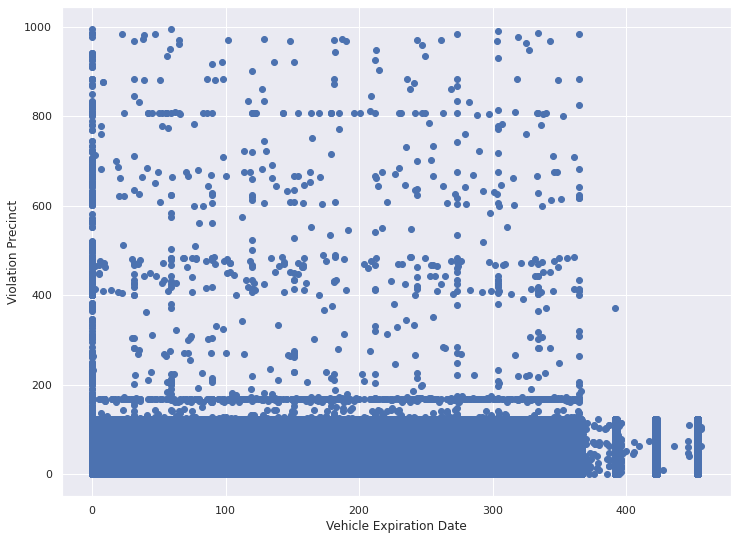

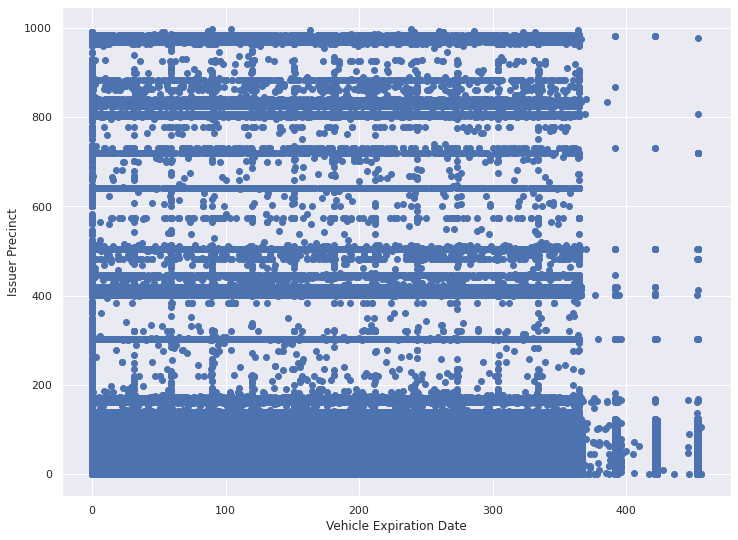

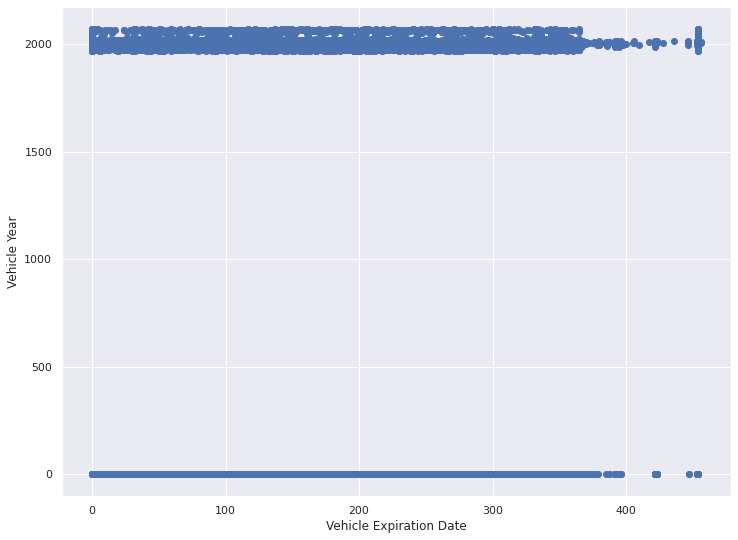

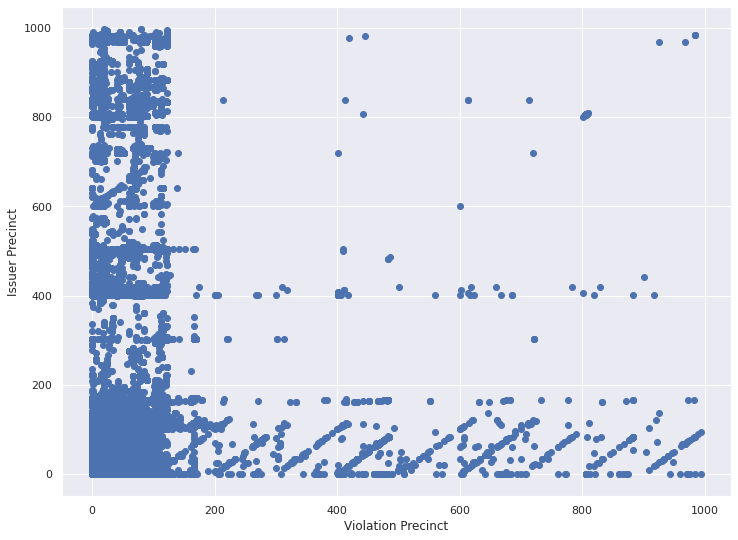

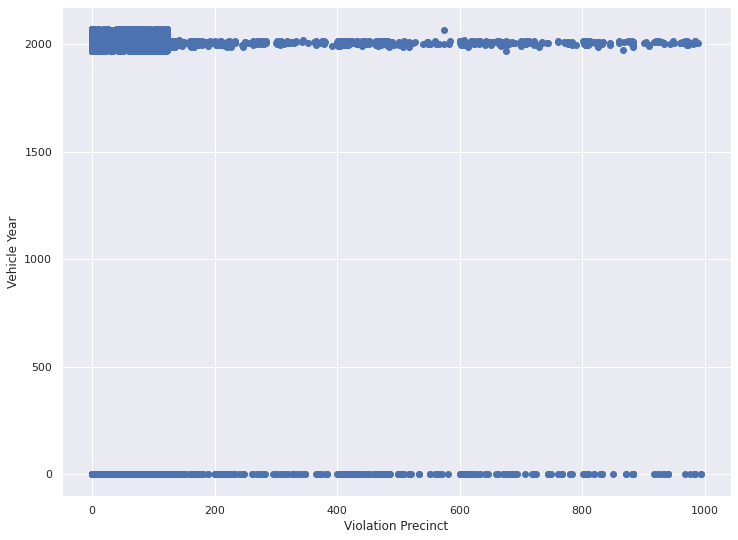

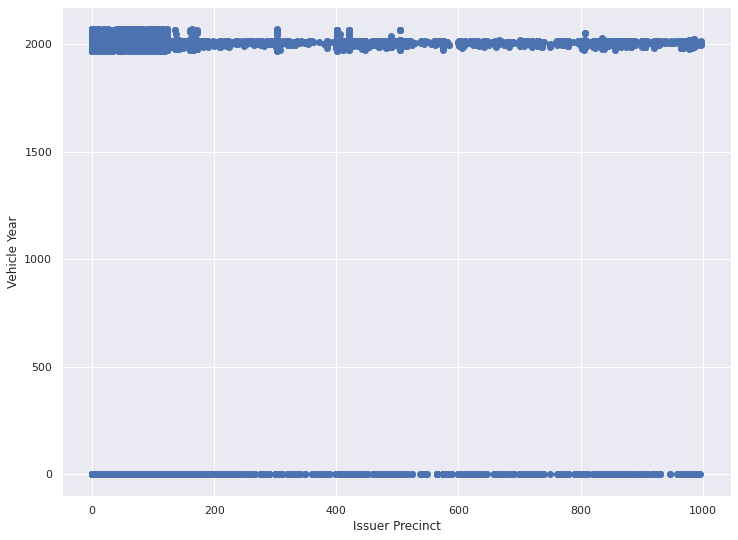

In [11]:
visualize_cols(clean_data_13_14)

# Standardization

In [6]:
scaler = StandardScaler()
clean_data_13_14_std = scaler.fit_transform(clean_data_13_14)

In [9]:
def calc_std(arr):
    stdev = 0
    mean = sum(arr)/(len(arr))
    
    for obs in arr:
        stdev += (obs-mean)**2
        
    
    return math.sqrt(stdev/(len(arr)))

In [10]:
def calc_avg(arr):
    return sum(arr)/len(arr)

In [11]:
clean_data_13_14_std.shape

(9100277, 4)

In [47]:
for col in range(clean_data_13_14_std.shape[1]):
    print(calc_std(clean_data_13_14_std[:,col]))
    print(calc_avg(clean_data_13_14_std[:,col]))
    print("\n\n")

0.9999999999978986
-2.6465196196642606e-13



0.999999999997922
5.9861551317548214e-15



1.0000000000065135
2.4999778876432283e-13



1.000000000013147
6.167684496253403e-13





### PCA

In [12]:
pca = PCA()
pca.fit(clean_data_13_14_std)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

##### This is the percentage of the variance accounted for by each indivaidual principal component
##### sum of all these values is equal to one i.e. 100%

In [13]:
pca.explained_variance_ratio_

array([0.39006665, 0.33620364, 0.16518535, 0.10854436])

In [51]:
pca.explained_variance_

array([1.56026678, 1.34481469, 0.66074149, 0.43417748])

Text(0, 0.5, 'Cumulative Explained Variance')

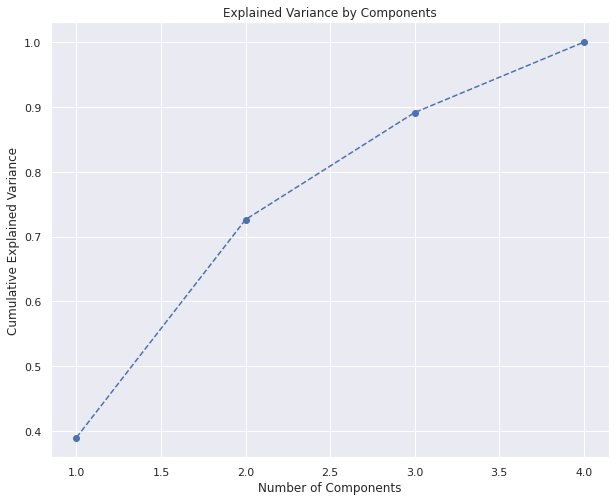

In [56]:
plt.figure(figsize=(10,8))
plt.plot(range(1,5),pca.explained_variance_ratio_.cumsum(),marker='o',linestyle='--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

 - rule of thumb is to preserve around 80 % of the variance. 
 - No option but to keep 3 components

perform PCA with the chosen number of components

In [7]:
pca = PCA(n_components = 3)

# Fit the model to data with the selected number of components = 3
pca.fit(clean_data_13_14_std)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [8]:
# calculating the resulting components scores for the elements in our data set
scores_pca = pca.transform(clean_data_13_14_std)
scores_pca

array([[-0.48119558, -0.38908717, -0.54979775],
       [-0.41376822, -0.95092214, -0.00614268],
       [-0.70651515,  0.3368095 ,  1.83746967],
       ...,
       [ 0.60015104, -0.62144809, -0.14749629],
       [ 0.11052716,  2.31422076,  0.08146   ],
       [ 0.23471604,  1.2804753 ,  1.07893317]])

In [11]:
scores_pca[0:2000].shape

(2000, 3)

In [12]:
# incorporating the newly obtained PCA scores in the K-means algorithm
# determining the Within Cluster Sum of Squares(WCSS) for each solution by Elbow Method

# K means clustering with PCA
# Fitting K Means using transformed data from the PCA
wcss = []
for i in range(1,21):
    kmeans_pca = KMeans(n_clusters = i, init = 'k-means++',random_state = 42)
    kmeans_pca.fit(scores_pca[0:2000])
    wcss.append(kmeans_pca.inertia_)

determining the number of clusters 
kink or elbow in the WCSS graph is at the 3 clusters mark

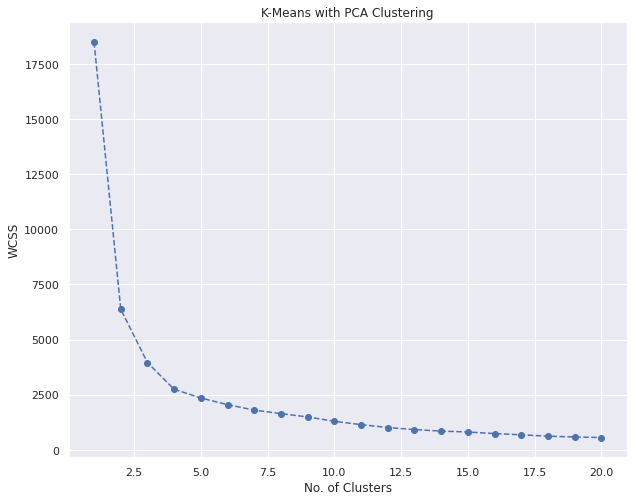

In [14]:
# plotting the WCSS against the number of components on a graph
plt.figure(figsize=(10,8))
plt.plot(range(1,21), wcss, marker='o', linestyle='--')
plt.xlabel('No. of Clusters')
plt.ylabel('WCSS')
plt.title('K-Means with PCA Clustering')
plt.show()

## Implementing KMeans after PCA and determining the no. of reqd clusters

In [17]:
kmeans_pca = KMeans(n_clusters=3,init='k-means++',random_state=42)
kmeans_pca.fit(scores_pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [1]:
%memit

UsageError: Line magic function `%memit` not found.


In [ ]:
clean_data_13_14_std

In [39]:
# Creating New Data Frame
kmeans_pca_13_14 = pd.concat([clean_data_13_14.reset_index(drop=True),pd.DataFrame(scores_pca)],axis=1)

In [40]:
kmeans_pca_13_14

,Vehicle Expiration Date,Violation Precinct,Issuer Precinct,Vehicle Year,0,1,2
0,243,33,33,2013.0,-0.481196,-0.389087,-0.549798
1,120,33,33,2012.0,-0.413768,-0.950922,-0.006143
2,59,33,33,0.0,-0.706515,0.336809,1.837470
3,304,33,33,2010.0,-0.515202,-0.107731,-0.816680
4,0,33,33,2012.0,-0.347827,-1.499814,0.523489
...,...,...,...,...,...,...,...
9100272,454,70,70,2011.0,0.436082,0.752822,-1.496554
9100273,454,70,70,2007.0,0.435434,0.755937,-1.493424
9100274,151,70,70,1996.0,0.600151,-0.621448,-0.147496
9100275,453,70,70,0.0,0.110527,2.314221,0.081460


In [ ]:
['Vehicle Expiration Date','Violation Precinct','Issuer Precinct','Vehicle Year','Component 1','Component 2','Component 3']

In [41]:
kmeans_pca_13_14.columns.values[-3:] = ['Component 1','Component 2','Component 3']

In [42]:
# the last column we add contains the pca k-means clutering labels
kmeans_pca_13_14['Segment K-means PCA'] = kmeans_pca.labels_

In [43]:
kmeans_pca_13_14.head()

,Vehicle Expiration Date,Violation Precinct,Issuer Precinct,Vehicle Year,Component 1,Component 2,Component 3,Segment K-means PCA
0,243,33,33,2013.0,-0.481196,-0.389087,-0.549798,0
1,120,33,33,2012.0,-0.413768,-0.950922,-0.006143,0
2,59,33,33,0.0,-0.706515,0.336809,1.837470,1
3,304,33,33,2010.0,-0.515202,-0.107731,-0.816680,0
4,0,33,33,2012.0,-0.347827,-1.499814,0.523489,0


In [46]:
kmeans_pca_13_14['Segment'] = kmeans_pca_13_14['Segment K-means PCA'].map({0:'first',
																		   1:'second',
																		   2:'third'})

In [47]:
kmeans_pca_13_14

,Vehicle Expiration Date,Violation Precinct,Issuer Precinct,Vehicle Year,Component 1,Component 2,Component 3,Segment K-means PCA,Segment
0,243,33,33,2013.0,-0.481196,-0.389087,-0.549798,0,first
1,120,33,33,2012.0,-0.413768,-0.950922,-0.006143,0,first
2,59,33,33,0.0,-0.706515,0.336809,1.837470,1,second
3,304,33,33,2010.0,-0.515202,-0.107731,-0.816680,0,first
4,0,33,33,2012.0,-0.347827,-1.499814,0.523489,0,first
...,...,...,...,...,...,...,...,...,...
9100272,454,70,70,2011.0,0.436082,0.752822,-1.496554,2,third
9100273,454,70,70,2007.0,0.435434,0.755937,-1.493424,2,third
9100274,151,70,70,1996.0,0.600151,-0.621448,-0.147496,2,third
9100275,453,70,70,0.0,0.110527,2.314221,0.081460,1,second


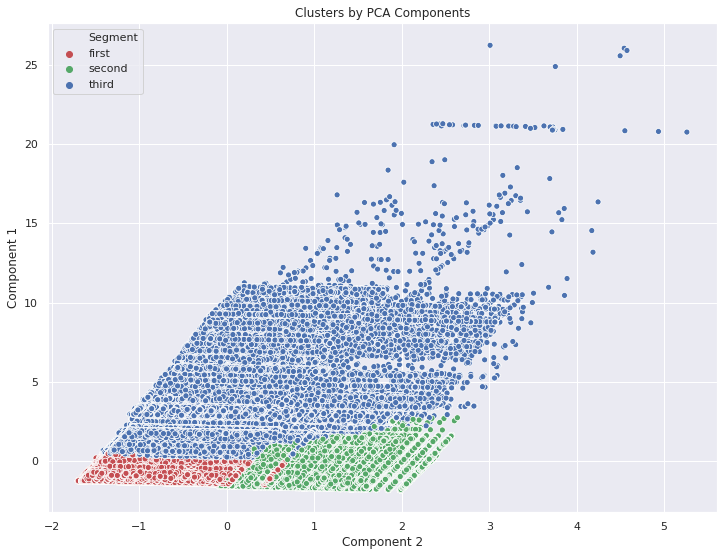

In [48]:
# Visualization
x_axis = kmeans_pca_13_14['Component 2']
y_axis = kmeans_pca_13_14['Component 1']
plt.figure(figsize=(12,9))
sns.scatterplot(x_axis,y_axis,hue=kmeans_pca_13_14['Segment'],palette=['r','g','b'])
plt.title('Clusters by PCA Components')
plt.show()

In [49]:
kmeans_pca_13_14.to_hdf('kmeans_pca_13_14.h5', key='df', mode='w')

/home/abishek/miniconda3/envs/anishka/lib/python3.8/site-packages/pandas/core/generic.py:2490: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block3_values] [items->Index(['Vehicle Expiration Date', 'Segment'], dtype='object')]

  pytables.to_hdf(


In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('/mnt/data/qe_dask_GBP/clean_data/clean_data_15.csv')

In [4]:
df.columns

Index(['Unnamed: 0', 'Vehicle Expiration Date', 'Violation Precinct',
       'Issuer Precinct', 'Vehicle Year'],
      dtype='object')